# Notebook Setup

## Usual libraries

In [1]:
from math import *
from datetime import datetime
from functools import partial

import pandas as pd
import numpy as np
import scipy as sp

## Graph

In [2]:
import matplotlib.pyplot as plt
import seaborn as sb

from matplotlib.ticker import FuncFormatter

## DataFrame Display Helpers

In [3]:
def display(dataframe, maxrows=999, fmt=None):
    from IPython.display import display
    
    previousMaxRow = pd.options.display.max_rows
    previousFloatFormat = pd.options.display.float_format    
    
    pd.options.display.max_rows = maxrows
    if fmt: 
        pd.options.display.float_format = fmt
        
    display(dataframe)
    
    pd.options.display.max_rows = previousMaxRow
    pd.options.display.float_format = previousFloatFormat
    

def colorNegativeRed(val):
    if val < 0 :
        return 'color: red'
    else:
        return 'color: black'
    
def formatCash(v, *args, decimals=True, zeroBar=True):
    if np.isnan(v):
        return "nan"
    elif zeroBar and v == 0:
        return "-"
    else:
        if decimals:
            fmt = "{}${:,.2f}"
        else:
            fmt = "{}${:,.0f}"                
        
        return fmt.format(v<0 and "-" or "", abs(v))
    
formatInt = "{:,.0f}".format
formatPct = "{:.1%}".format

CASH_FORMATTER = FuncFormatter(partial(formatCash, decimals=False, zeroBar=False))
PCT_FORMATTER_DEC_1 = FuncFormatter(formatPct)
PCT_FORMATTER_DEC_NONE = FuncFormatter("{:.0%}".format)

# Using Pyne
## Liabraries

In [4]:
from  pyne import *

## Showing A tree

In [5]:
from pyne.render import GraphvizEngine
import graphviz

def showTree(root: Node, prune, discard):
    root.createPlaceholders()
    eng = GraphvizEngine(root, "${:,.0f}", "${:,.0f}")
    graph = eng.render("svg", prune, discard)
    return graphviz.Source(graph)

# Build The "Drill or No Drill" Example

## Repeating pattern: sell or drill (then find or not)

In this problem we encounter the same pattern at 3 different places with different probabilities of finding oil.

We will program a helper function to create this pattern only once and use it where we need.

In [6]:
def drillSellPattern(pFindOil):
    return Decision(
        "Sell or Drill",
        [
            Transition("Sell", 90_000),
            Transition("Drill",-100_000, target=
                       Event("Find Oil", [
                           Transition("Yes", 800_000, pFindOil),
                           Transition("No")
                       ])
                      )
        ]
    )

## Creating the tree

In [7]:
root = Decision("Conduct Survey", [
    Transition("Yes", -30_000, target=Event("Survey Positive", [
        Transition("Yes", probability=0.3,target=drillSellPattern(1/2)),
        Transition("No", target=drillSellPattern(1/7))
    ])),
    Transition("No", target=drillSellPattern(1/4))
])

## Let's Have a Quick Look

Before we go any further, let's have a quick look at this tree.

You will notice a few things:

- Costs/payouts are associated with transitions
- Many blue "Done" octogons have been generated automatically: These are the "end games" and will contain the possible
  outcomes
- No calculation has been done so far
- Some event transitions don't have a probability: they are complementary.

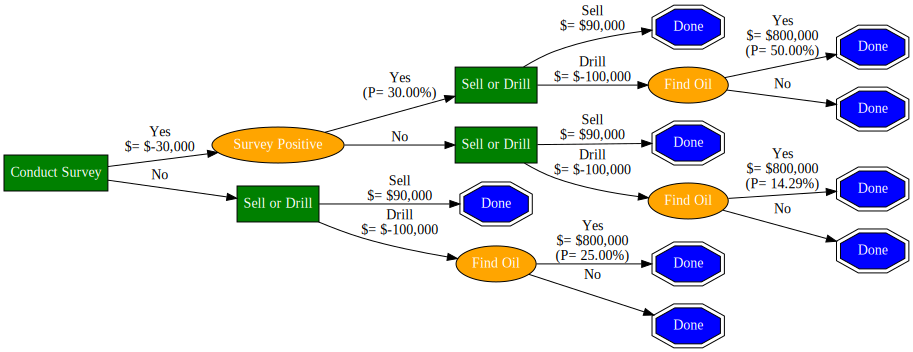

In [8]:
showTree(root, False, False)

# Solving a Tree
## Creating a Solver
### Actualizing Cashflows

Ultimately, we will use a strategy to solve the tree and this strategy will compare "**strategic values**" (scalars).

Cashflows (or costs, or payouts, or impacts...) associated with transitions, on the other hand, can take three different forms:
- Scalars. Ex: -3.12
- Indexed Series. Ex:  0:-10, 1:1, 2:1, 3:1 5:11
- Time Perios Series. Ex: 2018-1:-100, 2018-02:10, 2018-03:10, ..., 2018-12:110

If you are using series, your end games will be series too. These series have to be actualized into a scalar before being compared by a strategy. You may provide your own actualization by subclassing **ValueActualizer**, but here are some basic methods provided:

- Just add them up: Use **SUMMING_ACTUALIZER**
- Calculate NPV: Instantiate one of **IndexNPV** or **PeriodNPV**, depending how you indexed your series.
- Calculate Time To Recovery (delay between going in red and coming back in black.): Use **TTR_ACTUALIZER**

Here, thouth, we are using scalar cashflows. They are simply added together and the end game is already a scalar. There isn't much to do and we will use **SCALAR_ACTUALIZER** that simply retures the received scalar.

In [9]:
from pyne.valueactualizer import SCALAR_ACTUALIZER

## Creating a Decision Strategy

A decision strategy looks at the distribution of possible outcomes for each transitions and decides which one to take. It thus has two things to do.

- Transform a distribution into a scalar
- Compare these scalars and pick the favourite

Typical ways of transforming a distribution into a scalar are included in the library:

- Pick the minimum possible
- Pick the maximum possible
- Use the expected value

Typical ways of picking your favourite transition included in the library:
- Choose the maximum
- Choose the minimum
- Custom implementation

You are free to compose your strategy from any combinations of those (or your custom implementations). It is so common to have a strategy of picking the max expected value, that the library includes a helper called **createMaxExpected**. 

Since we are trying to demonstrate a few things, we will not use the shorcut and build it manually since it is not too difficult anyway.

In [10]:
from pyne.strategy import Strategy, rpExpected, selectMaxRP

strategy = Strategy(rpExpected, selectMaxRP)

## Creating a Solver

Because solving a tree might be done multiple times (think: sensitivity analysis...), we create a solver object that has everything readily available to do everything in one call.

The solver's properties are typically entirely set from the constructor, but you may also update it's properties after the fact. We Will show this with limits a little later (and will not impose any limits here).

In [11]:
solver = Solver(root, strategy, SCALAR_ACTUALIZER)

## Solving 

This part is quite straight forward

In [12]:
solver.solve()

## Let's look at it a few different ways

When looking at a solved tree, you might want to highlight the computed strategy to make it stand out. There are two ways of doing that.

- Grey out the nodes that are not part of the selected possibilities (discard=True)
- Prune out all the branches that are not possible (prune=True)

Let's have a look. Notice that the strategic value of every state is now displayed in nodes ("R$ = ..."). Also notice that end games that are possible given this strategy also include a probability ("(P= ...)"). By looking at those end games, you actually have a disctribution of the possible outcomes.

### No Highlighting

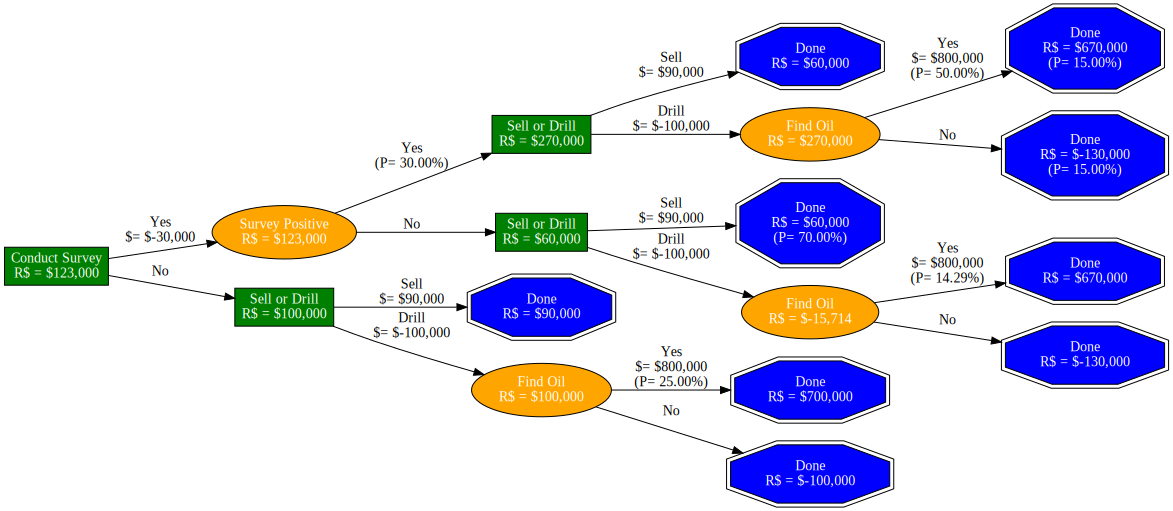

In [13]:
showTree(root, False, False)

### Grey Out Discarded Paths

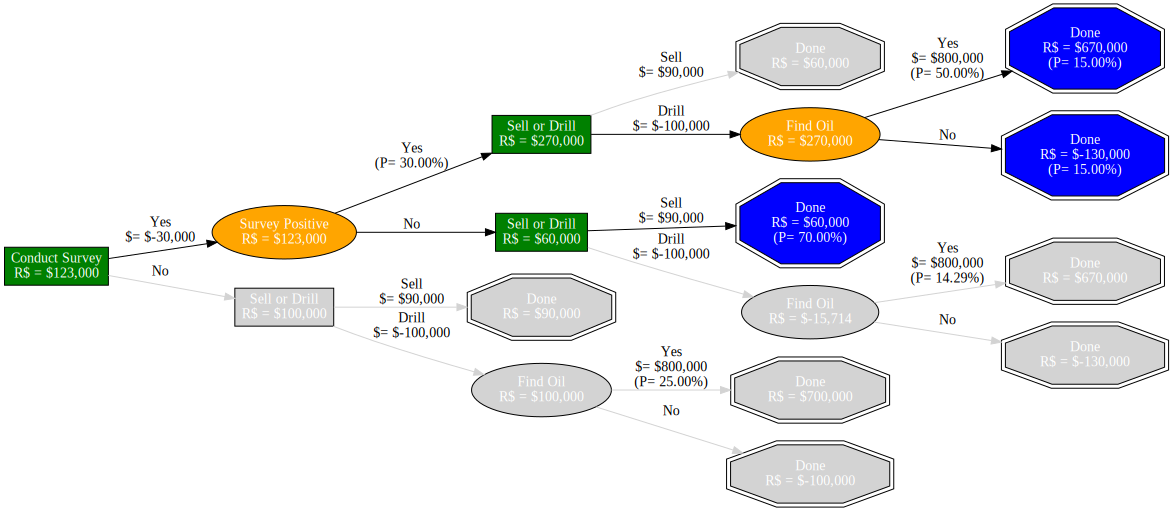

In [14]:
showTree(root, False, True)

### Prune Out Discarded Paths

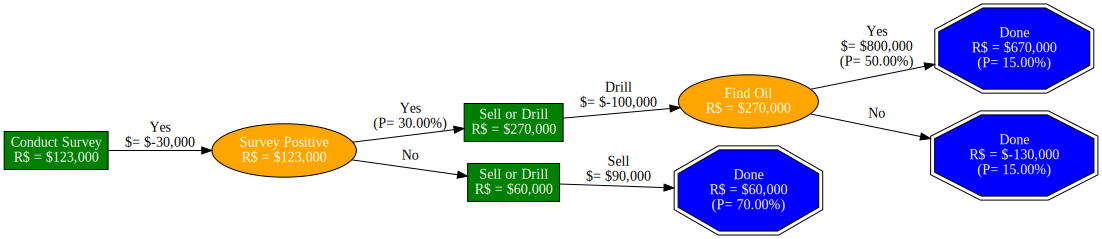

In [15]:
showTree(root, True, False)

# Imposing Limits

Now... looking at expected value has the problem that it does not say much about what will actually happen to you. What if you had limits that you would not tolerate. 

In this example, we will imagine that we have \$125,000 in our pockets and bankruptcy is not an option. Formally, we will impose a limit that in no way, should we find ourselves with a cashflow lower than -\$125,000.

Now remember that we are using scalar cashflows, but that need not be. We thus allow limits to be imposed either on cashflows or their actualized values. You can do so directly on these, or on their distribution. Finally, you may also impose limits on the strategic value.

Let's add the limit and re-solve the tree. Notice that dead ends (nodes that violate the limit or could lead to a violation of the limit) are red, and so are transitions there. Should there be no possible path, you will simply get a very red tree.

Needless to say that the solution is different.

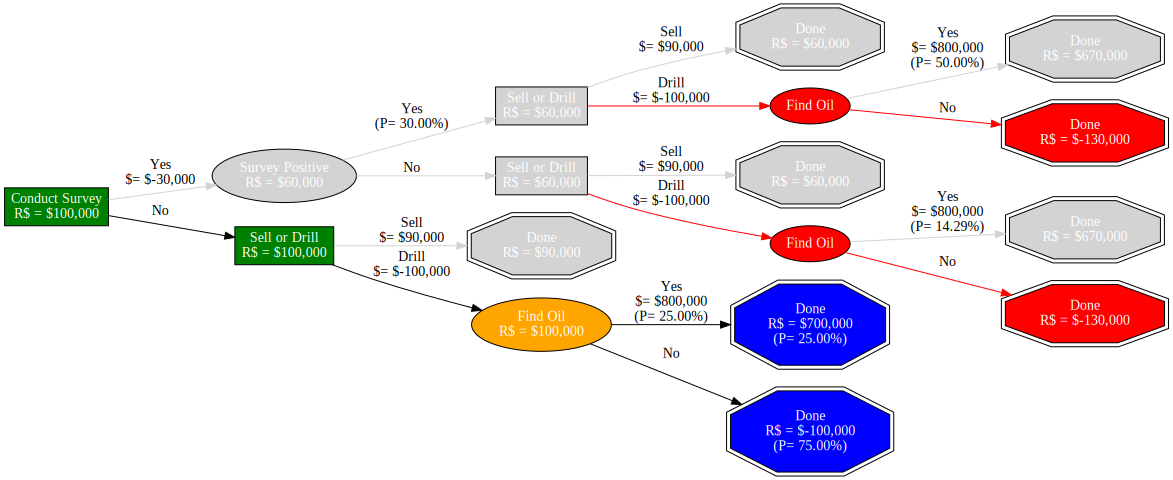

In [16]:
from pyne.limits import Limit, valueUnderThreshold

solver.cashflowLimits.append(
    Limit("Loosing more than I can tolerate", valueUnderThreshold(-125_000))
)

solver.solve()
showTree(root, False, True)

# Sensitivity Analysis

Now... we assumed a lot of things in there. The library includes a sensitivity analysis functionnality. 

## Defining Variables

The first step to a sensitivity analysis is to choose what numbers you want to play with. These will be called **Variable**.

Variables include:

- A name
- A method to actually go and put a specific number on your tree
- A domain to explore (the values at which you want to calculate)
- A base case (the central value)

As for the domain, if you are really sure what you are doing, you may provide only two values (high, low), but if something is non-linear or, more typically, if you would like to know how your strategy behaves, you should provide multiple points (100 sounds like a fair starting point).

Also, the base case doesn't have to be the number you used while building your tree.

We will then try to see the impact of changing the following:

- Probability of finding oil without the survey
- Cost of the survey
- Value of finding oil
- Value of selling the land
- Cost of drilling

Note that there are an infinite number of ways of modifying these amounts. I could have been a bit more strategical when building the tree, but I wanted to both keep the intro simple and demonstrate a few other things here. You could obviously optimise this, but we won't feel it too bad here.

In [17]:
from pyne.sensitivity import *

def setPOil(p):
    # you can navigate the tree by transition names
    root.transit("No", "Drill", "Yes").probability = p

def setCostSurvey(cost):
    root.transit("Yes").payout = cost
    
def setPSurvey(p):
    root.transit("Yes", "Yes").probability = p
    
def setVOil(vOil):
    # you can flip through the nodes 
    for n in root.getNodesFlat():
        if n.name == "Find Oil":
            n.transit("Yes").payout = vOil

def setVLand(vLand):    
    for n in root.getNodesFlat():
        if n.name == "Sell or Drill":
            n.transit("Sell").payout = vLand

def setCostDrill(cDrill):
    for n in root.getNodesFlat():
        if n.name == "Sell or Drill":
            n.transit("Drill").payout = cDrill
    
variables = [
    Variable("Prob of oil (no survey)", setPOil, .25, np.linspace(.10, .4, 100)),
    Variable("Cost of survey", setCostSurvey, -30_000, np.linspace(-20_000, -40_000, 100)),
    Variable("Probability of successful survey", setPSurvey, .3, np.linspace(.1, .5, 100)),
    Variable("Value of finding oil", setVOil, 800_000, np.linspace(600_000, 1_000_000, 100)),    
    Variable("Value of the land", setVLand, 90_000, np.linspace(60_000, 300_000, 100)),    
    Variable("Cost of drilling", setCostDrill, -100_000, np.linspace(-80_000, -120_000, 100)),    
]

## Defining Outputs

Ultimately, everytime you recalculate the tree, you will be interested in the impact. To do this, you will define an **Output** for every value you are interested in.

Outputs are created by providing:

- A name
- A method to extract the value from the tree

Here, we will try to extract the following values:

- Strategic value of the whole thing
- Strategic value if we conduct the survey
- Strategic value if we do not conduct the survey
- Do we conduct the survey
- Could the strategy involve drilling (a bit more challenging !)

In [18]:
def strategyCouldLeadToDrilling(node: Node):
    if isinstance(node, Decision):
        if node.results.choice.name == "Drill":
            return True
        else:
            return strategyCouldLeadToDrilling(node.results.choice.target)
    elif isinstance(node, Event):
        for t in node.transitions:
            if strategyCouldLeadToDrilling(t.target):
                return True
    return False


outputs = [
    Output("Value of project", lambda: root.results.strategicValue),
    Output("Value with survey", lambda: root.transit("Yes").target.results.strategicValue),
    Output("Value without survey", lambda: root.transit("No").target.results.strategicValue),
    Output("Survey", lambda: root.results.choice.name),
    Output("Might end up drilling", lambda: strategyCouldLeadToDrilling(root) and "yes" or "no")
]

## Running the Sensitivity Analysis

At this point, running the sensitivity analysis is a matter of creating a **SensitivityAnalysis**. All the computation actually happens during the creation.

In [19]:
sa = SensitivityAnalysis(solver, variables, outputs)

## The Numerical stuff

### Base Cases

You can get the base cases using the following:

In [20]:
display(sa.baseValues)

,base
Value of project,100000
Value with survey,60000
Value without survey,100000
Survey,No
Might end up drilling,yes


### Extremums

You can display the extremums using the following code.

Note that the extremums are given even for non numeric values. These will be "low" and "high" in sort order. If it happens to make sense for you, use them. If it does not make sense (here, it does not), be careful not to read a meaning that doesn't exist.

In [21]:
display(sa.extremums)

Value of project         Value with survey  \
                                              Low    High               Low   
Prob of oil (no survey)                     90000  220000             60000   
Cost of survey                             100000  133000             50000   
Probability of successful survey           100000  100000             60000   
Value of finding oil                        90000  150000             60000   
Value of the land                          100000  300000             30000   
Cost of drilling                            90000  129000             60000   

                                         Value without survey         Survey  \
                                    High                  Low    High    Low   
Prob of oil (no survey)            60000                90000  220000     No   
Cost of survey                    133000               100000  100000     No   
Probability of successful survey   60000               100000  100000     No   
Value of finding oil               60000                90000  150000     No   
Value of the land                 270000               100000  300000     No   
Cost of drilling                  129000                90000  120000     No   

                                      Might end up drilling       
                                 High                   Low High  
Prob of oil (no survey)            No                    no  yes  
Cost of survey                    Yes                   yes  yes  
Probability of successful survey   No                   yes  yes  
Value of finding oil               No                    no  yes  
Value of the land                  No                    no  yes  
Cost of drilling                  Yes                    no  yes

### Indivitual responses

You can look at the impact of each Varialbles a bit more closely. Here's what it means for us:

In [22]:
for vn in sa.variableNames:
    print()
    print()
    print(vn)
    display(sa.individualResponses[vn], 6)



Prob of oil (no survey)


,Prob of oil (no survey),Value of project,Value with survey,Value without survey,Survey,Might end up drilling
0,0.100000,90000.000000,60000.0,90000.000000,No,no
1,0.103030,90000.000000,60000.0,90000.000000,No,no
2,0.106061,90000.000000,60000.0,90000.000000,No,no
...,...,...,...,...,...,...
97,0.393939,215151.515152,60000.0,215151.515152,No,yes
98,0.396970,217575.757576,60000.0,217575.757576,No,yes
99,0.400000,220000.000000,60000.0,220000.000000,No,yes




Cost of survey


,Cost of survey,Value of project,Value with survey,Value without survey,Survey,Might end up drilling
0,-20000.000000,133000.000000,133000.000000,100000.0,Yes,yes
1,-20202.020202,132797.979798,132797.979798,100000.0,Yes,yes
2,-20404.040404,132595.959596,132595.959596,100000.0,Yes,yes
...,...,...,...,...,...,...
97,-39595.959596,100000.000000,50404.040404,100000.0,No,yes
98,-39797.979798,100000.000000,50202.020202,100000.0,No,yes
99,-40000.000000,100000.000000,50000.000000,100000.0,No,yes




Probability of successful survey


,Probability of successful survey,Value of project,Value with survey,Value without survey,Survey,Might end up drilling
0,0.100000,100000.0,60000.0,100000.0,No,yes
1,0.104040,100000.0,60000.0,100000.0,No,yes
2,0.108081,100000.0,60000.0,100000.0,No,yes
...,...,...,...,...,...,...
97,0.491919,100000.0,60000.0,100000.0,No,yes
98,0.495960,100000.0,60000.0,100000.0,No,yes
99,0.500000,100000.0,60000.0,100000.0,No,yes




Value of finding oil


,Value of finding oil,Value of project,Value with survey,Value without survey,Survey,Might end up drilling
0,600000.000000,90000.00000,60000.0,90000.00000,No,no
1,604040.404040,90000.00000,60000.0,90000.00000,No,no
2,608080.808081,90000.00000,60000.0,90000.00000,No,no
...,...,...,...,...,...,...
97,991919.191919,147979.79798,60000.0,147979.79798,No,yes
98,995959.595960,148989.89899,60000.0,148989.89899,No,yes
99,1000000.000000,150000.00000,60000.0,150000.00000,No,yes




Value of the land


,Value of the land,Value of project,Value with survey,Value without survey,Survey,Might end up drilling
0,60000.000000,100000.000000,30000.000000,100000.000000,No,yes
1,62424.242424,100000.000000,32424.242424,100000.000000,No,yes
2,64848.484848,100000.000000,34848.484848,100000.000000,No,yes
...,...,...,...,...,...,...
97,295151.515152,295151.515152,265151.515152,295151.515152,No,no
98,297575.757576,297575.757576,267575.757576,297575.757576,No,no
99,300000.000000,300000.000000,270000.000000,300000.000000,No,no




Cost of drilling


,Cost of drilling,Value of project,Value with survey,Value without survey,Survey,Might end up drilling
0,-80000.000000,129000.000000,129000.000000,120000.000000,Yes,yes
1,-80404.040404,128878.787879,128878.787879,119595.959596,Yes,yes
2,-80808.080808,128757.575758,128757.575758,119191.919192,Yes,yes
...,...,...,...,...,...,...
97,-119191.919192,90000.000000,60000.000000,90000.000000,No,no
98,-119595.959596,90000.000000,60000.000000,90000.000000,No,no
99,-120000.000000,90000.000000,60000.000000,90000.000000,No,no


## Visualizing the Sensitivity Analysis

All those tables are available if you want to consult them, but the sensitivity analysis also includes a graphical recap of all of this.

### Extremums

Extremums are probably the most immediate thing to look at to put things in perspectives. Here, only numerical values are included.

Each graph represents the impact of every variables on a specific output.

As a very technical note, I assign the return value of the call to a dummy variable because Jupyter tends to display the result of the last line, which clutters the space.

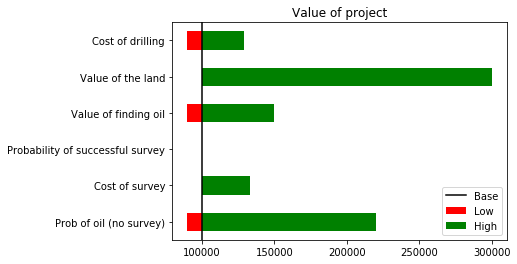

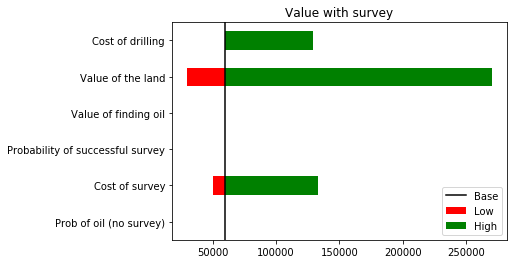

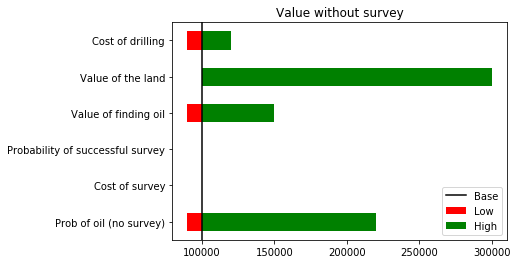

In [23]:
dummy = sa.getImpactGraphs()

### Individual Responses


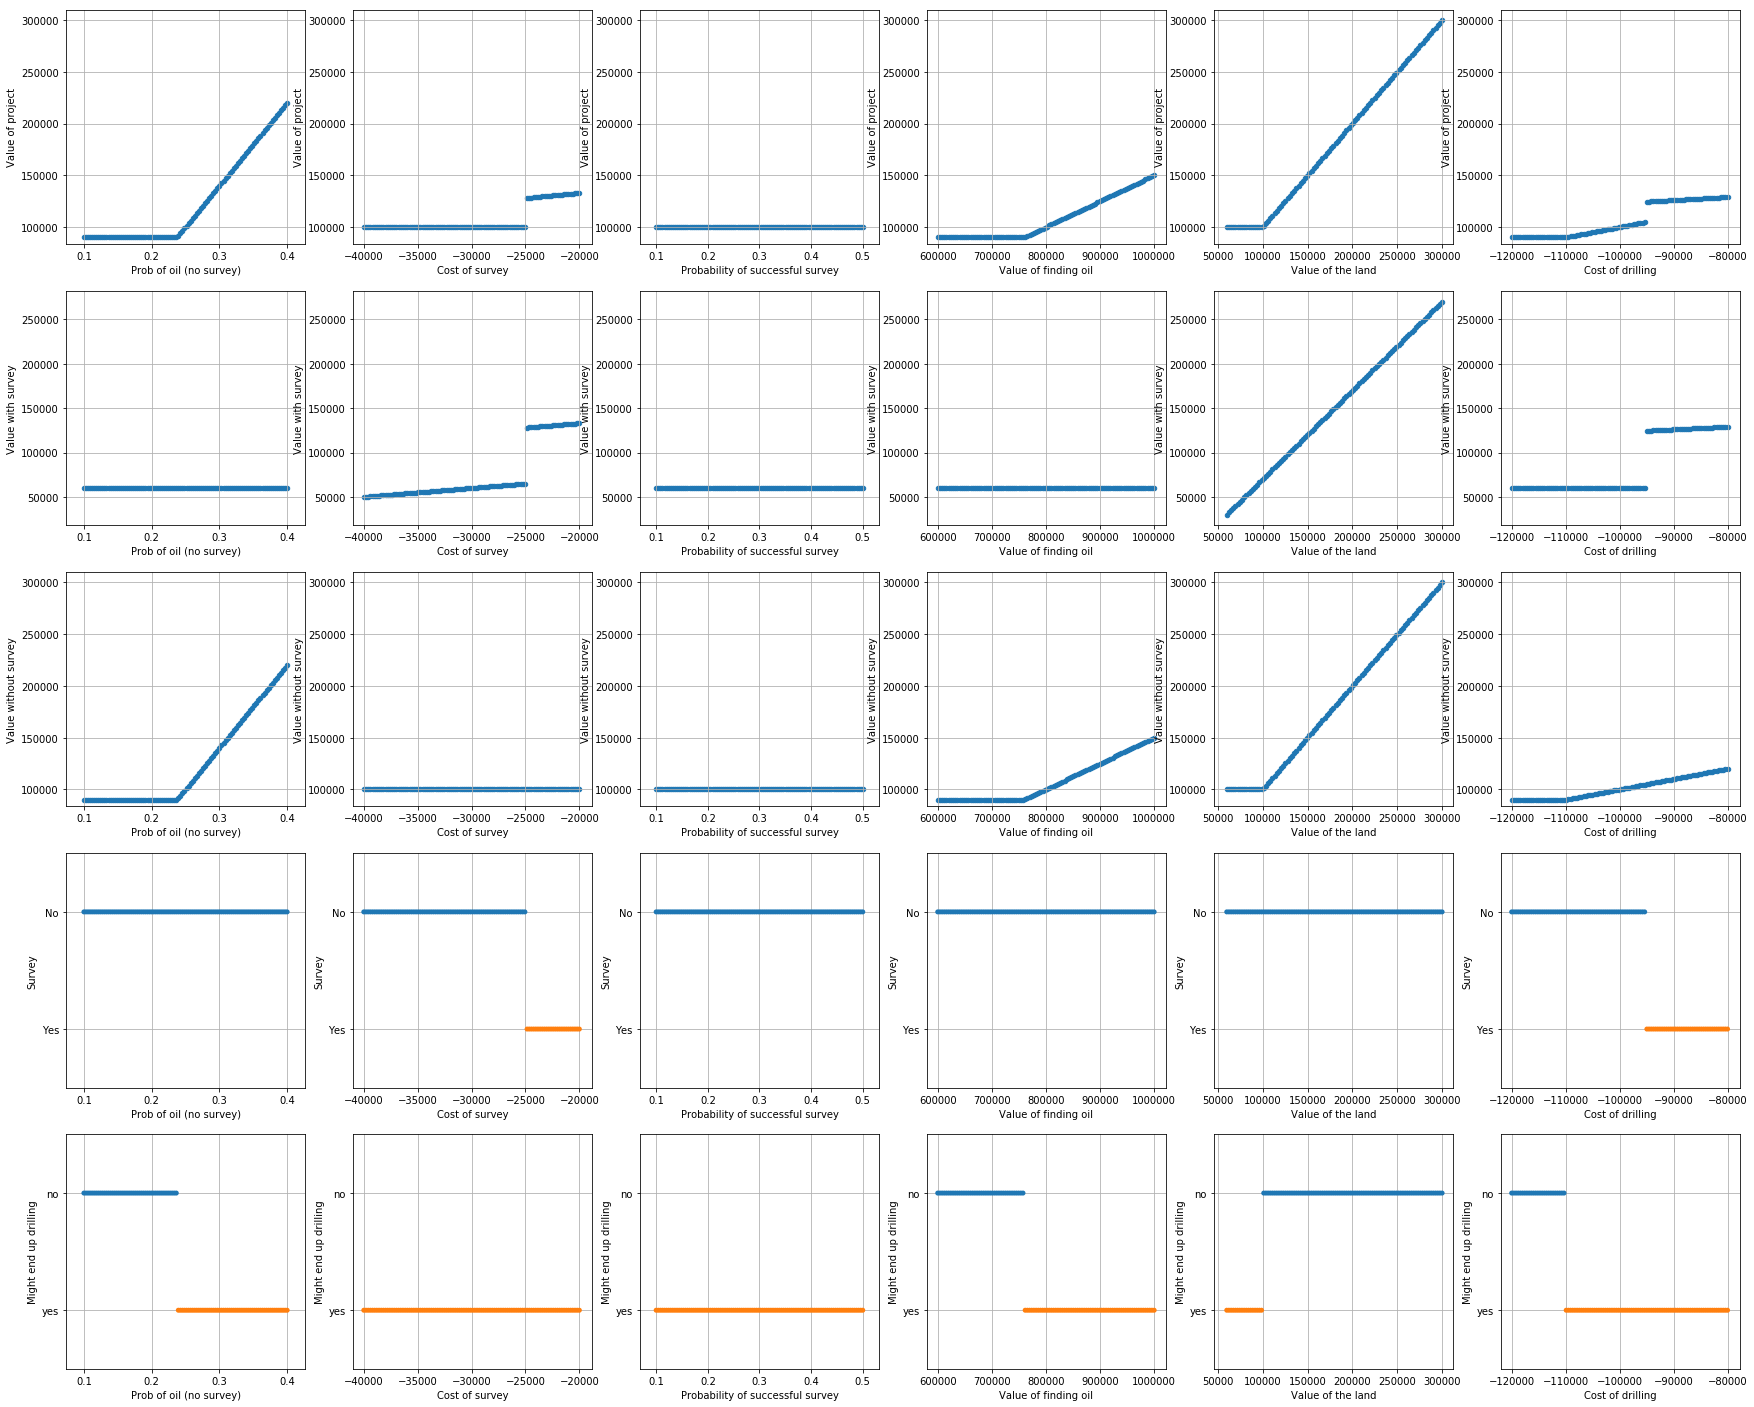

In [24]:
dummy = sa.getIndivisualResponseGraphs()

## Again, Without the Limit

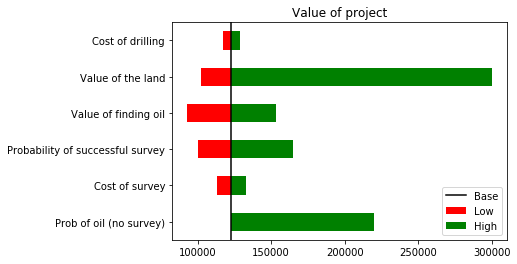

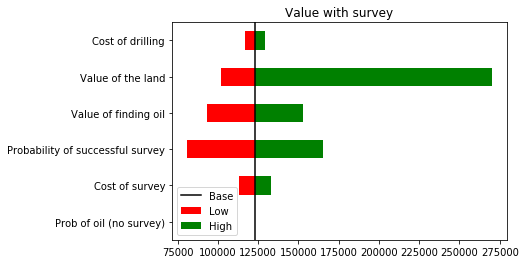

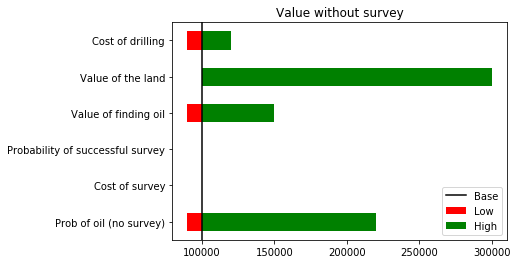

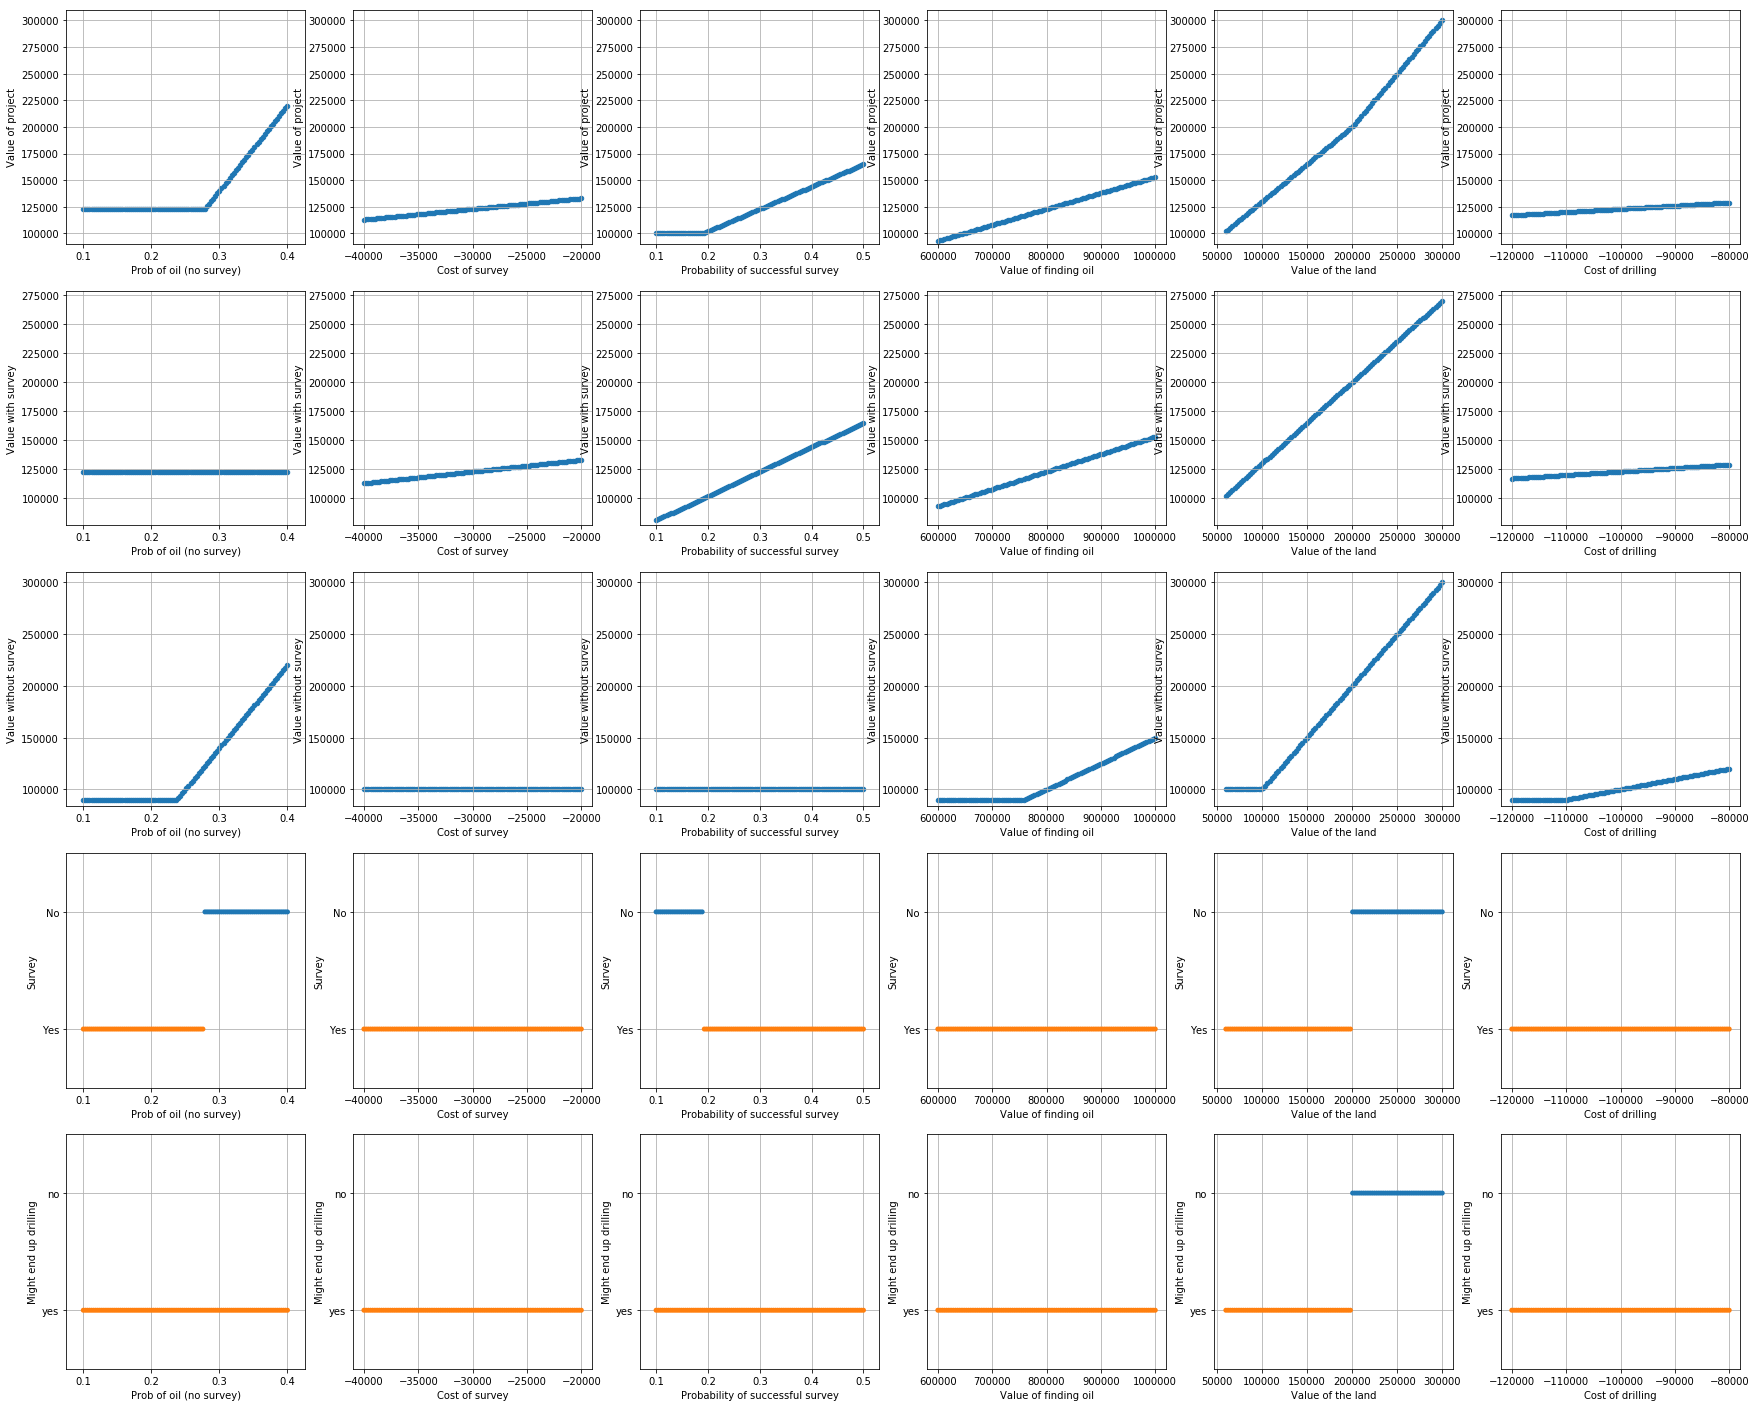

In [25]:
solver.cashflowLimits.clear()
sa = SensitivityAnalysis(solver, variables, outputs)
sa.getImpactGraphs()
dummy=sa.getIndivisualResponseGraphs()